**Team Members: Kuntamukkala Pavan Kumar, Arjun Amla, Priyanka Kumari**

# Gesture Recognition
In this group project, we built 3D Conv model, TimeDistributed GRU Model and ConvLSTM2D model  that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import os
import imageio
from imageio import imread
import datetime
import os
from PIL import Image, ImageEnhance, ImageFilter
import IPython.display as display
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
import warnings
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Tue Jun 27 09:17:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_path='/kaggle/input/motion-gesture/Project_data/train/'
val_path='/kaggle/input/motion-gesture/Project_data/val/'

In [6]:
train_doc = np.random.permutation(open('/kaggle/input/motion-gesture/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/motion-gesture/Project_data/val.csv').readlines())
df=pd.DataFrame(train_doc)
df.head()
dim_x, dim_y =80, 80 #Due to limited resources and time, we are limiting the size of resized image to 80,80
im_idx=range(0,30,2) # We are using only 15 frames / images in every folder instead of using 30 frames to reduce burden of computation

Here we wrote a code to know the what are different sizes of images present in train dataset and its corresponding count.

In [7]:
l1=[]
for i in range(len(train_doc)):
    x=os.listdir('/kaggle/input/motion-gesture/Project_data/train/'+train_doc[i].strip().split(';')[0])
    for idx,j in enumerate(x):
        l1.append(Image.open('/kaggle/input/motion-gesture/Project_data/train/'+train_doc[i].strip().split(';')[0]+'/'+j).size)
Counter(l1)

Counter({(160, 120): 14370, (360, 360): 5520})

From the above we can see that, there are 2 different dimensions of images in train dataset and are as follows:
- Number of Images of 160 x 120 size are: 14370
- Number of Images of 360 x 360 size are: 5520

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `x`,`y` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, augmentation= False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx=im_idx
    x,y=dim_x,dim_y
    while True:
        t=np.random.permutation(folder_list)
        if len(t)%batch_size==0:
            num_batches=int(len(t)/batch_size)
        else:
            num_batches=(len(t)//batch_size)+1

        for batch in range(num_batches):# we iterate over the number of batches
            batch_data=np.zeros((batch_size,len(img_idx),x,y,3))# len(img_idx) is the number of images you use for each video, (x,y) is the final size of the input images and 3 is the number of channels RGB
            batch_labels=np.zeros((batch_size,5))# batch_labels is the one hot representation of the output
            for folder in range(batch_size):# iterate over the batch_size
                if folder+(batch*batch_size) >= len(t):
                    break
                imgs=os.listdir(source_path+t[folder+(batch*batch_size)].split(';')[0])# read all the images in the folder
                aug_t=None
                if augmentation==True and rn.randint(0,1)==1: #randomnly chosing which images to augment by using randint
                    aug_t=rn.randint(0,2)#choosing augmentation type by using randint
                for idx, item in enumerate(img_idx):#  Iterate over the frames/images of a folder to read them in
                    image=Image.open(source_path+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    if image.size[1]>image.size[0]:#Checking for size of image and cropping as per the size
                        img_diff=image.size[1]-image.size[0]
                        cr_s=img_diff//2
                        cr_e=cr_s+image.size[0]
                        image=image.crop((cr_s,0,cr_e,image.size[0]))
                    elif image.size[0]>image.size[1]:#Checking for size of image and cropping as per the size
                        img_diff= image.size[0]-image.size[1]
                        cr_s=img_diff//2
                        cr_e=cr_s+image.size[1]
                        image=image.crop((cr_s,0,cr_e,image.size[1]))
                    img_r=image.resize((x,y))
                    if aug_t==0:
                        img_r=ImageEnhance.Sharpness(img_r).enhance(2)# increasing sharpness of image
                    elif aug_t==1:
                        img_r=ImageEnhance.Brightness(img_r).enhance(1.2)# increasing brightness of image
                    elif aug_t==2:
                        img_r.filter(ImageFilter.DETAIL)#increasing detailing of image
                    img_rn=(img_r-np.min(img_r))/(np.max(img_r)-np.min(img_r))#Normalizing the image using min, max (Since There were no outlier values in train dataset)
                    batch_data[folder,idx,:,:,0] = img_rn[:,:,0]#feeding the normalized image
                    batch_data[folder,idx,:,:,1] = img_rn[:,:,1]#feeding the normalized image
                    batch_data[folder,idx,:,:,2] = img_rn[:,:,2]#feeding the normalized image
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
test_gen = generator(train_path, train_doc,20, augmentation = True) #Testing Generator Function

In [11]:
next(test_gen)[0][0][0]

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 20


array([[[0.4745098 , 0.50196078, 0.49019608],
        [0.46666667, 0.50196078, 0.49019608],
        [0.4745098 , 0.52156863, 0.50588235],
        ...,
        [0.43529412, 0.43921569, 0.40784314],
        [0.42352941, 0.43137255, 0.40392157],
        [0.41176471, 0.43137255, 0.40392157]],

       [[0.44705882, 0.48235294, 0.47058824],
        [0.45098039, 0.49019608, 0.4745098 ],
        [0.4627451 , 0.50980392, 0.49411765],
        ...,
        [0.42352941, 0.43137255, 0.40392157],
        [0.41568627, 0.42352941, 0.40392157],
        [0.40392157, 0.42745098, 0.40784314]],

       [[0.43529412, 0.4745098 , 0.4627451 ],
        [0.43921569, 0.48235294, 0.46666667],
        [0.45098039, 0.49411765, 0.47843137],
        ...,
        [0.38823529, 0.41176471, 0.38431373],
        [0.38431373, 0.42352941, 0.39215686],
        [0.39607843, 0.43529412, 0.41176471]],

       ...,

       [[0.09019608, 0.10980392, 0.11372549],
        [0.19215686, 0.22745098, 0.24705882],
        [0.16470588, 0

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3D Model 1:

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling3D, GlobalAveragePooling2D, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

#write your model here
input_shape=(len(im_idx),dim_x,dim_y,3)
np.random.seed(30)

In [14]:
model1 = Sequential()
model1.add(Conv3D(8, kernel_size=(3,3,3), activation='relu', input_shape=input_shape,padding='same'))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model1.add(MaxPooling3D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam(lr=0.01)
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 80, 80, 8)     656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 40, 40, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 40, 40, 64)     13888     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 20, 20, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 76800)             0         
                                                                 
 dense (Dense)               (None, 256)               1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [17]:
model_name = 'model_init_exp1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
history1=model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 19.0829 - categorical_accuracy: 0.1786Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp1_2023-06-2410_32_11.986561/model-00001-19.08293-0.17857-1.25643-0.17969.h5
21/21 [==============================] - 121s 6s/step - loss: 19.0829 - categorical_accuracy: 0.1786 - val_loss: 1.2564 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5901 - categorical_accuracy: 0.2039
Epoch 2: saving model to model_init_exp1_2023-06-2410_32_11.986561/model-00002-1.59013-0.20387-1.25616-0.19531.h5
21/21 [==============================] - 42s 2s/step - loss: 1.5901 - categorical_accuracy: 0.2039 - val_loss: 1.2562 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - 

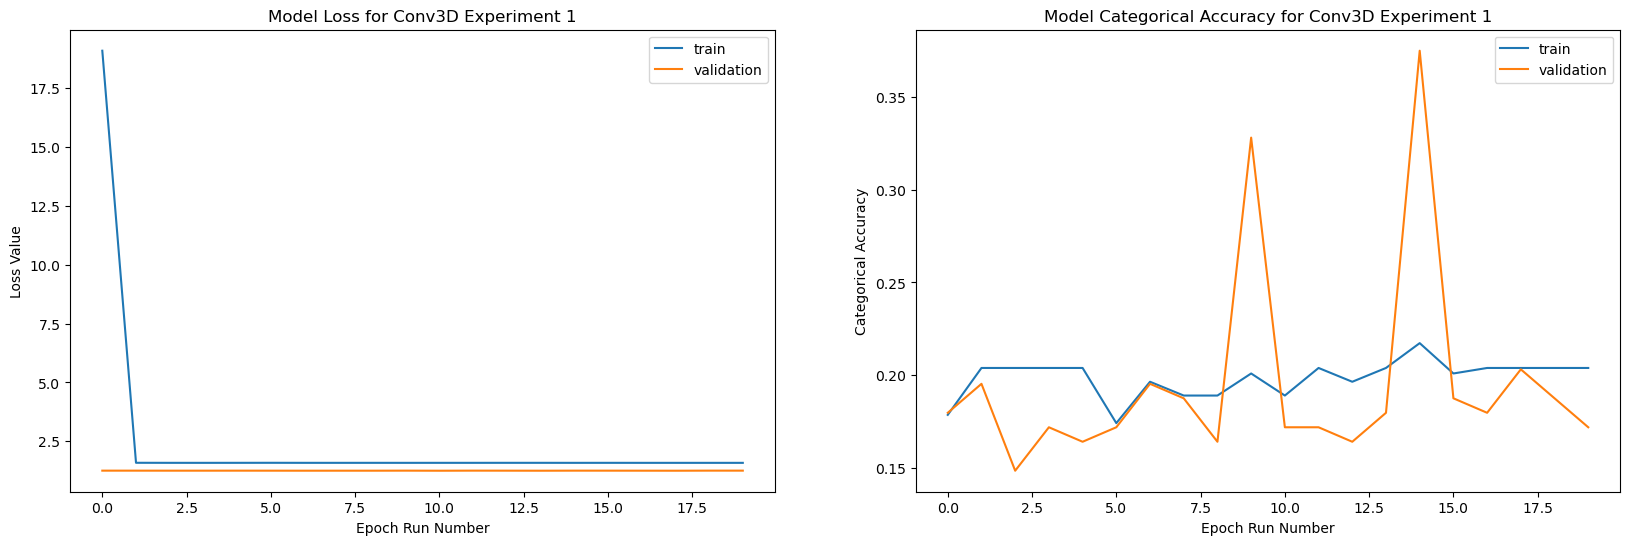

In [20]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history1.history['loss'])
ax_1 = plt.plot(history1.history['val_loss'])
plt.title('Model Loss for Conv3D Experiment 1')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history1.history['categorical_accuracy'])
ax_2 = plt.plot(history1.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Conv3D Experiment 1')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

We can see from the above plots that, Training Accuracy and Validation Accuracy during 20 epoch runs are 20% approximately. \
Lets increase epoch runs to 40 and add dropout layer of 0.2

### Conv3D Model 2:

In [22]:
model2 = Sequential()
model2.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=input_shape,padding='same'))
model2.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model2.add(MaxPooling3D(pool_size=2))
model2.add(BatchNormalization())

model2.add(Conv3D(128, kernel_size=3, activation='relu'))
model2.add(MaxPooling3D(pool_size=(1,2,2)))
model2.add(BatchNormalization())

model2.add(Conv3D(256,kernel_size=(1,3,3),activation='relu'))
model2.add(MaxPooling3D(pool_size=(1,2,2)))
model2.add(BatchNormalization())
           
model2.add(Conv3D(512,kernel_size=(1,3,3),activation='relu'))
model2.add(MaxPooling3D(pool_size=(1,2,2)))
model2.add(BatchNormalization())
           
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [23]:
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 80, 80, 32)    2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 15, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 7, 40, 40, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 38, 38, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 5, 19, 19, 128)  

In [24]:
model_name = 'model_init_exp2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
#Number of epochs increased to 40
history2=model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 17.3802 - categorical_accuracy: 0.2932
Epoch 1: saving model to model_init_exp2_2023-06-2410_32_11.986561/model-00001-17.38018-0.29315-12881.91406-0.35156.h5
21/21 [==============================] - 58s 3s/step - loss: 17.3802 - categorical_accuracy: 0.2932 - val_loss: 12881.9141 - val_categorical_accuracy: 0.3516 - lr: 0.0020
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 2.1387 - categorical_accuracy: 0.2351
Epoch 2: saving model to model_init_exp2_2023-06-2410_32_11.986561/model-00002-2.13870-0.23512-3606.57202-0.15625.h5
21/21 [==============================] - 46s 2s/step - loss: 2.1387 - categorical_accuracy: 0.2351 - val_loss: 3606.5720 - val_categorical_accuracy: 0.1562 - lr: 0.0020
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.6480 - categorical_accuracy: 0.2232
Epoch 3: saving model to model_init_exp2_2023-06-2410_32_11.986561/model-00003-1.64795-0.22321-794.85413-

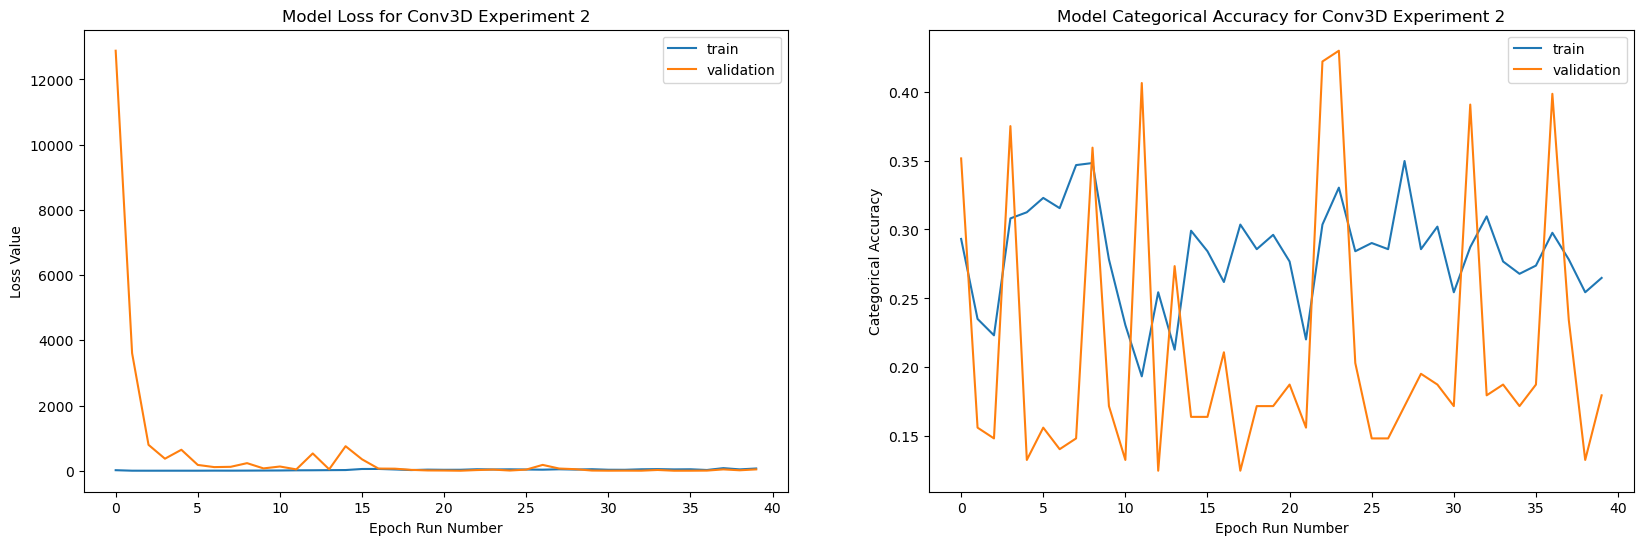

In [28]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history2.history['loss'])
ax_1 = plt.plot(history2.history['val_loss'])
plt.title('Model Loss for Conv3D Experiment 2')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history2.history['categorical_accuracy'])
ax_2 = plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Conv3D Experiment 2')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

For the above model during 40 epoch runs, we can see that:
- Training Accuracy is varying between 19% to 35% with an average around 27%
- Validataion Accuracy is varying between 5% to as high as 42%.
This model seems to be not performing well on our dataset.

### Conv3D Model 3:

In [14]:
model3 = Sequential()
model3.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=input_shape,padding='same'))
model3.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model3.add(MaxPooling3D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv3D(128, kernel_size=3, activation='relu'))
model3.add(MaxPooling3D(pool_size=(1,2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))

model3.add(Conv3D(256,kernel_size=(1,3,3),activation='relu'))
model3.add(MaxPooling3D(pool_size=(1,2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
           
model3.add(Conv3D(512,kernel_size=(1,3,3),activation='relu'))
model3.add(MaxPooling3D(pool_size=(1,2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
           
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(5, activation='softmax'))

In [16]:
optimiser = optimizers.Adam(lr=0.01)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 15, 80, 80, 32)    2624      
                                                                 
 conv3d_3 (Conv3D)           (None, 15, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 7, 40, 40, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 7, 40, 40, 64)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 5, 38, 38, 128)   

In [17]:
model_name = 'model_init_exp3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [19]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
history3=model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 55.7434 - categorical_accuracy: 0.2738Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp3_2023-06-2414_50_12.112194/model-00001-55.74342-0.27381-3033.57178-0.18750.h5
21/21 [==============================] - 109s 5s/step - loss: 55.7434 - categorical_accuracy: 0.2738 - val_loss: 3033.5718 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 7.1384 - categorical_accuracy: 0.2946
Epoch 2: saving model to model_init_exp3_2023-06-2414_50_12.112194/model-00002-7.13839-0.29464-1033.50122-0.35938.h5
21/21 [==============================] - 46s 2s/step - loss: 7.1384 - categorical_accuracy: 0.2946 - val_loss: 1033.5012 - val_categorical_accuracy: 0.3594 - lr: 0.0100
Epoch 3/40
21/21 [==============================] 

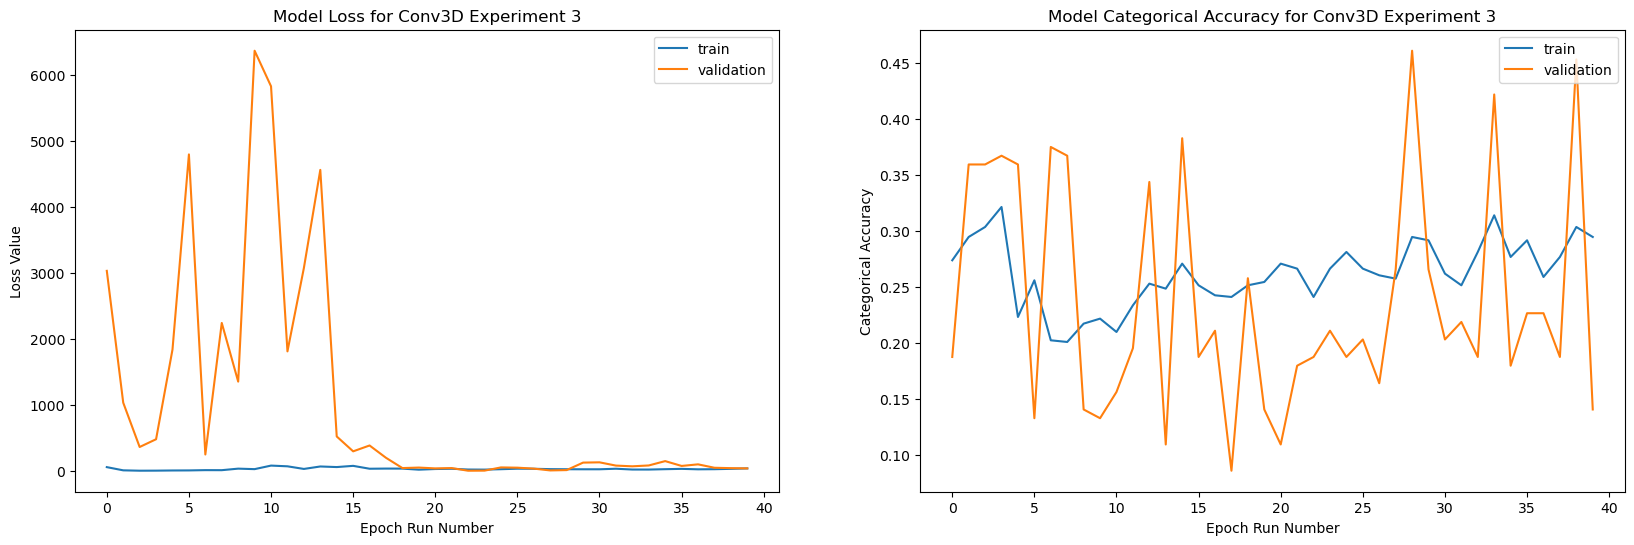

In [22]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history3.history['loss'])
ax_1 = plt.plot(history3.history['val_loss'])
plt.title('Model Loss for Conv3D Experiment 3')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history3.history['categorical_accuracy'])
ax_2 = plt.plot(history3.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Conv3D Experiment 3')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

-After adding dropouts, we can see that there is no significant change in its Training and Validation Accuracies.
-The performance of this model is not good as it is falling below 40%

### Conv3D Model 4:

In the above model, we witnessed an increase in number of trainable parameters.
Let us try using GlobalAveragePooling3D instead of Flatten Layer.

In [24]:
model4 = Sequential()
model4.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', input_shape=input_shape,padding='same'))
model4.add(Conv3D(64, kernel_size=3, activation='relu',padding='same'))
model4.add(MaxPooling3D(pool_size=2))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Conv3D(128, kernel_size=3, activation='relu'))
model4.add(MaxPooling3D(pool_size=(1,2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Conv3D(256,kernel_size=(1,3,3),activation='relu'))
model4.add(MaxPooling3D(pool_size=(1,2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
           
model4.add(Conv3D(512,kernel_size=(1,3,3),activation='relu'))
model4.add(MaxPooling3D(pool_size=(1,2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
           
model4.add(GlobalAveragePooling3D())
model4.add(Dense(512, activation='relu'))
model4.add(Dense(5, activation='softmax'))

In [25]:
optimiser = optimizers.Adam(lr=0.01)
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 15, 80, 80, 32)    2624      
                                                                 
 conv3d_8 (Conv3D)           (None, 15, 80, 80, 64)    55360     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 40, 40, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 7, 40, 40, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 7, 40, 40, 64)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 5, 38, 38, 128)   

In [26]:
model_name = 'model_init_exp4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [27]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
history4=model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 4.2764 - categorical_accuracy: 0.2307Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp4_2023-06-2414_50_12.112194/model-00001-4.27640-0.23065-447.96304-0.39844.h5
21/21 [==============================] - 53s 3s/step - loss: 4.2764 - categorical_accuracy: 0.2307 - val_loss: 447.9630 - val_categorical_accuracy: 0.3984 - lr: 0.0100
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 2.1636 - categorical_accuracy: 0.3438
Epoch 2: saving model to model_init_exp4_2023-06-2414_50_12.112194/model-00002-2.16361-0.34375-58.41674-0.19531.h5
21/21 [==============================] - 46s 2s/step - loss: 2.1636 - categorical_accuracy: 0.3438 - val_loss: 58.4167 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/40
21/21 [==============================] - ETA: 0s 

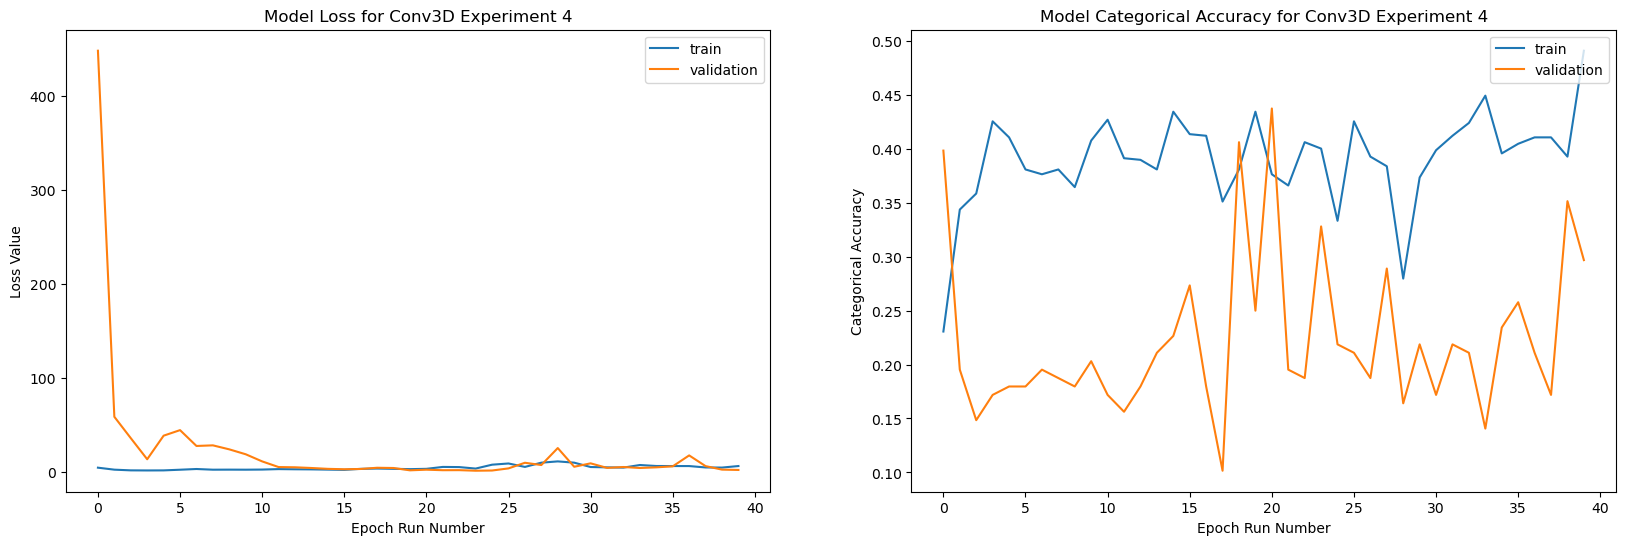

In [30]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history4.history['loss'])
ax_1 = plt.plot(history4.history['val_loss'])
plt.title('Model Loss for Conv3D Experiment 4')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history4.history['categorical_accuracy'])
ax_2 = plt.plot(history4.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Conv3D Experiment 4')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

- From the above model, we can see that by using GlobalAveragePooling2D reduced number of trainable parameters to 1/8 of flatten layer.
- Yet No significant performance increase can be observed.
- The training and validation accuracies still hover around 40 - 50%

### Time Distributed Conv2D + GRU Model 5:

In [20]:
model5 = Sequential()
model5.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(BatchNormalization())

model5.add(TimeDistributed(
Conv2D(64, (3,3), activation='relu')))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(BatchNormalization())

model5.add(TimeDistributed(GlobalAveragePooling2D()))
model5.add(TimeDistributed(Dense(64, activation='relu')))
model5.add(BatchNormalization())

model5.add(GRU(64))
model5.add(BatchNormalization())
model5.add(Dense(5, activation='softmax'))

In [21]:
optimiser = optimizers.Adam(lr=0.01)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 15, 78, 78, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 39, 39, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 15, 39, 39, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 37, 37, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 18, 18, 64)  

In [22]:
model_name = 'model_init_exp5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [23]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
history5=model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5691 - categorical_accuracy: 0.3438Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp5_2023-06-2516_51_22.745172/model-00001-1.56912-0.34375-1.68360-0.17969.h5
21/21 [==============================] - 64s 3s/step - loss: 1.5691 - categorical_accuracy: 0.3438 - val_loss: 1.6836 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2092 - categorical_accuracy: 0.4568
Epoch 2: saving model to model_init_exp5_2023-06-2516_51_22.745172/model-00002-1.20916-0.45685-1.82279-0.21875.h5
21/21 [==============================] - 44s 2s/step - loss: 1.2092 - categorical_accuracy: 0.4568 - val_loss: 1.8228 - val_categorical_accuracy: 0.2188 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss

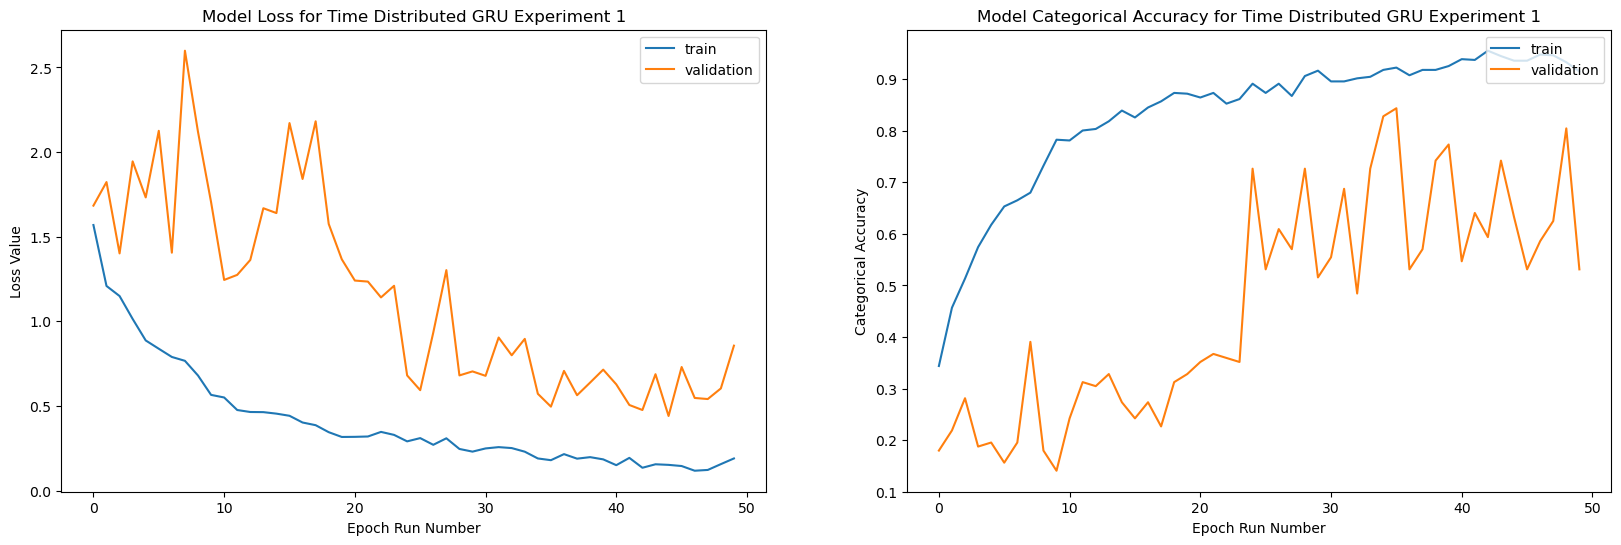

In [26]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history5.history['loss'])
ax_1 = plt.plot(history5.history['val_loss'])
plt.title('Model Loss for Time Distributed GRU Experiment 1')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history5.history['categorical_accuracy'])
ax_2 = plt.plot(history5.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Time Distributed GRU Experiment 1')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

- From the above GRU model, we can see that the model seems to be overfitting on training data as the number of epochs increases. The Training accuracy reached a max of 95%
- Now Lets see what happens to performance of GRU model if we add dropout.

### Time Distribted Conv2D + GRU Model 6:

In [34]:
model6 = Sequential()
model6.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(TimeDistributed(GlobalAveragePooling2D()))
model6.add(TimeDistributed(Dense(64, activation='relu')))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))

model6.add(GRU(64))
model6.add(BatchNormalization())
model6.add(Dense(5, activation='softmax'))

In [35]:
optimiser = optimizers.Adam(lr=0.01)
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 78, 78, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 39, 39, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_12 (Bat  (None, 15, 39, 39, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 15, 39, 39, 32)    0         
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 37, 37, 64)   18496     
 stributed)                                           

In [36]:
model_name = 'model_init_exp6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [37]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
history6=model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5512 - categorical_accuracy: 0.3378Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp6_2023-06-2516_51_22.745172/model-00001-1.55123-0.33780-1.86142-0.17969.h5
21/21 [==============================] - 46s 2s/step - loss: 1.5512 - categorical_accuracy: 0.3378 - val_loss: 1.8614 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2837 - categorical_accuracy: 0.4107
Epoch 2: saving model to model_init_exp6_2023-06-2516_51_22.745172/model-00002-1.28367-0.41071-1.87235-0.18750.h5
21/21 [==============================] - 44s 2s/step - loss: 1.2837 - categorical_accuracy: 0.4107 - val_loss: 1.8724 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss

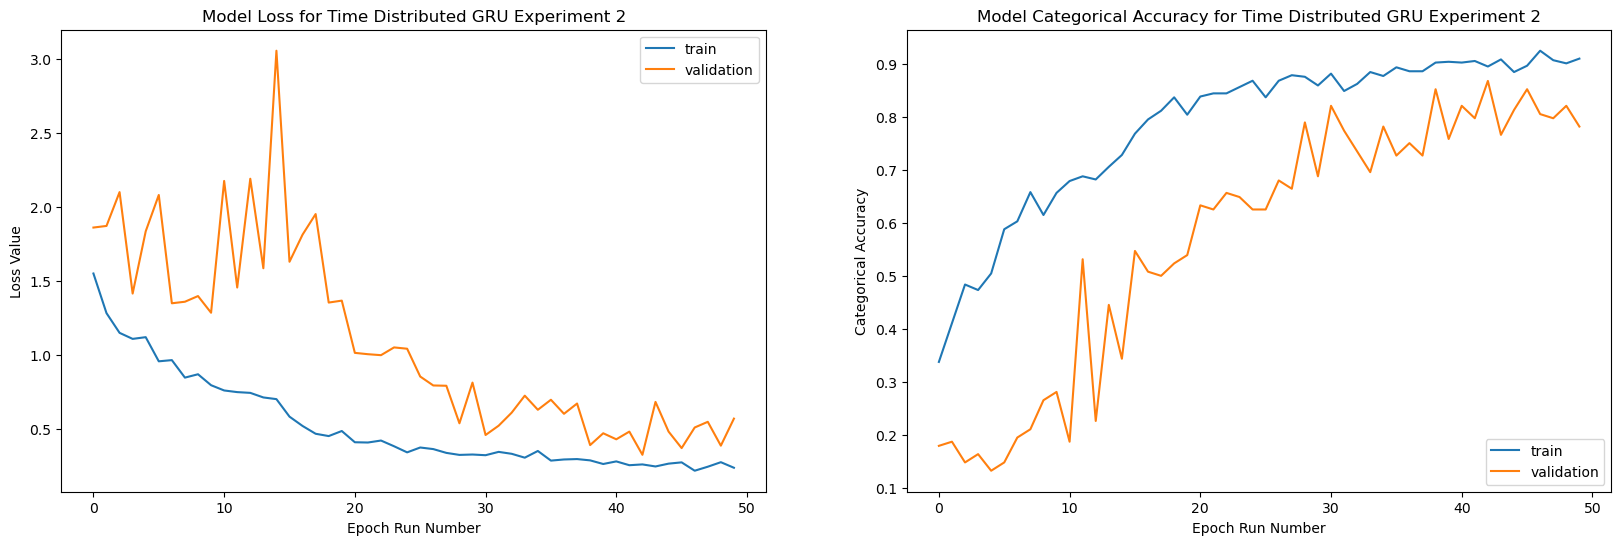

In [41]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history6.history['loss'])
ax_1 = plt.plot(history6.history['val_loss'])
plt.title('Model Loss for Time Distributed GRU Experiment 2')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history6.history['categorical_accuracy'])
ax_2 = plt.plot(history6.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Time Distributed GRU Experiment 2')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='lower right')

- After adding Droupouts, we can see that max value for Training Accuracy is around 92%
- The overfitting problem seems to be resolved, as there is no significant difference between training and validation accuracies.
- During last epoch run, the Training and Validation accuracies are 90% and 78%.

So far, this is the best model we have obtained.

### Time Distribted Conv-LSTM2D Model 7:

In [55]:
model7 = Sequential()
model7.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model7.add(BatchNormalization())
model7.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model7.add(BatchNormalization())
model7.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model7.add(BatchNormalization())
model7.add(TimeDistributed(Dense(64, activation='relu')))
model7.add(BatchNormalization())
model7.add(GlobalAveragePooling2D())
model7.add(Dense(64, activation='relu'))
model7.add(Dense(5, activation='softmax'))

In [56]:
optimiser = optimizers.Adam(lr=0.01)
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 15, 78, 78, 8)    224       
 stributed)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 15, 78, 78, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 76, 76, 16)   1168      
 stributed)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 15, 76, 76, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 74, 74, 8)        

In [57]:
model_name = 'model_init_exp7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [58]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
history7=model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.4441 - categorical_accuracy: 0.3229Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp7_2023-06-2516_51_22.745172/model-00001-1.44414-0.32292-1.32010-0.17969.h5
21/21 [==============================] - 61s 3s/step - loss: 1.4441 - categorical_accuracy: 0.3229 - val_loss: 1.3201 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2528 - categorical_accuracy: 0.4167
Epoch 2: saving model to model_init_exp7_2023-06-2516_51_22.745172/model-00002-1.25276-0.41667-1.39028-0.14062.h5
21/21 [==============================] - 46s 2s/step - loss: 1.2528 - categorical_accuracy: 0.4167 - val_loss: 1.3903 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss

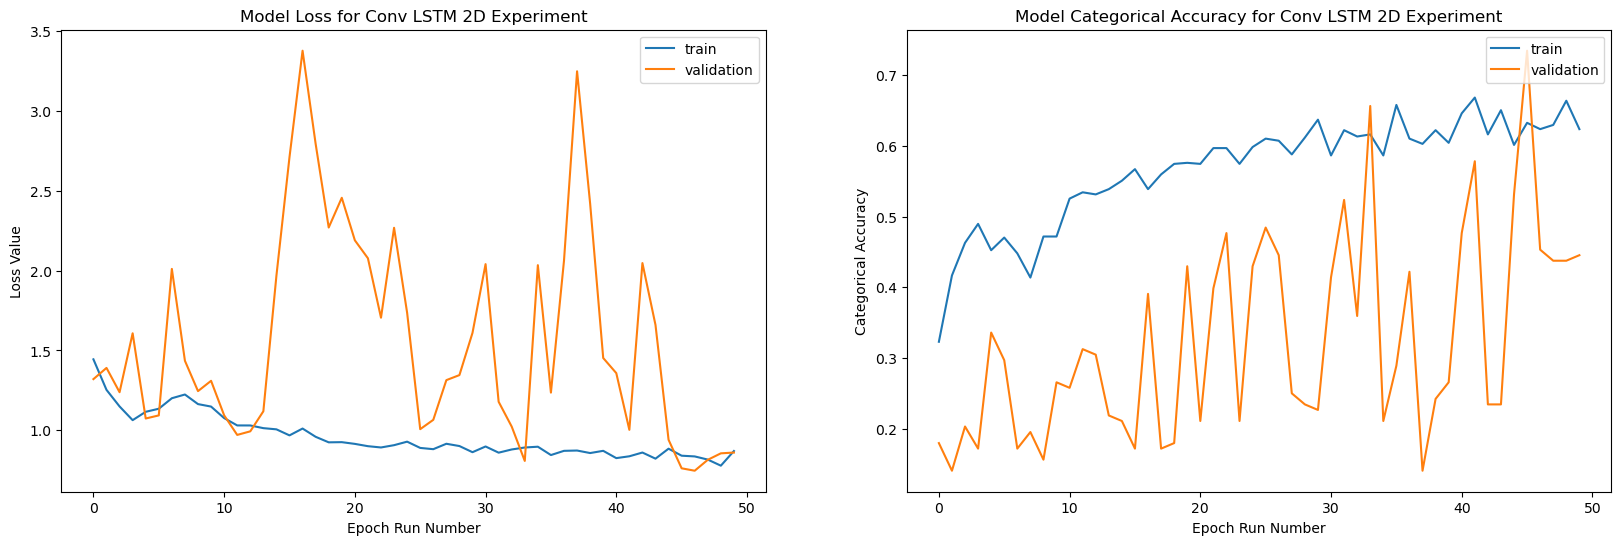

In [61]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history7.history['loss'])
ax_1 = plt.plot(history7.history['val_loss'])
plt.title('Model Loss for Conv LSTM 2D Experiment')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history7.history['categorical_accuracy'])
ax_2 = plt.plot(history7.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Conv LSTM 2D Experiment')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

- From the ConvLSTM2D model, we can see that even though the amount of trainable parameters are far less than Conv3D or GRU, its performance here is not good.
- Even though the training accuracy is satisfactory (reaching max of 67%), it is not satisfactory with regards to Validation Accuracy.

In [54]:
!tar -zcvf modelh6files.tar.gz /kaggle/working/model_init_exp6_2023-06-2516_51_22.745172

tar: Removing leading `/' from member names
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00022-0.41035-0.84375-1.00648-0.62500.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00044-0.24871-0.90774-0.68448-0.76562.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00036-0.28824-0.89286-0.69895-0.72656.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00034-0.30804-0.88393-0.72660-0.69531.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00014-0.71458-0.70536-1.58665-0.44531.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00050-0.23998-0.90923-0.57164-0.78125.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00021-0.41214-0.83780-1.01551-0.63281.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172/model-00004-1.10988-0.47321-1.41588-0.16406.h5
/kaggle/working/model_init_exp6_2023-06-2516_51_22.745172

### Transfer Learning using MobileNetV2 Model 8:

In [88]:
from keras.applications import MobileNetV2
mobile_net=MobileNetV2(include_top=False)

In [96]:
model8=Sequential()
model8.add(TimeDistributed(mobile_net,input_shape=input_shape))
model8.add(BatchNormalization())
model8.add(TimeDistributed(MaxPooling2D((2,2))))
model8.add(TimeDistributed(GlobalAveragePooling2D()))

model8.add(GRU(64))

model8.add(Dense(64, activation='relu'))

model8.add(Dense(5,activation='softmax'))

In [97]:
optimiser = optimizers.Adam(lr=0.01)
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 15, 2, 2, 1280)   2257984   
 stributed)                                                      
                                                                 
 batch_normalization_30 (Bat  (None, 15, 2, 2, 1280)   5120      
 chNormalization)                                                
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 1280)         0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 64)              

In [98]:
model_name = 'model_init_exp8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [99]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [100]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [101]:
history8=model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6847 - categorical_accuracy: 0.2351Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp8_2023-06-2516_51_22.745172/model-00001-1.68467-0.23512-1.32807-0.16406.h5
21/21 [==============================] - 64s 3s/step - loss: 1.6847 - categorical_accuracy: 0.2351 - val_loss: 1.3281 - val_categorical_accuracy: 0.1641 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6179 - categorical_accuracy: 0.1905
Epoch 2: saving model to model_init_exp8_2023-06-2516_51_22.745172/model-00002-1.61788-0.19048-1.35991-0.34375.h5
21/21 [==============================] - 46s 2s/step - loss: 1.6179 - categorical_accuracy: 0.1905 - val_loss: 1.3599 - val_categorical_accuracy: 0.3438 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss

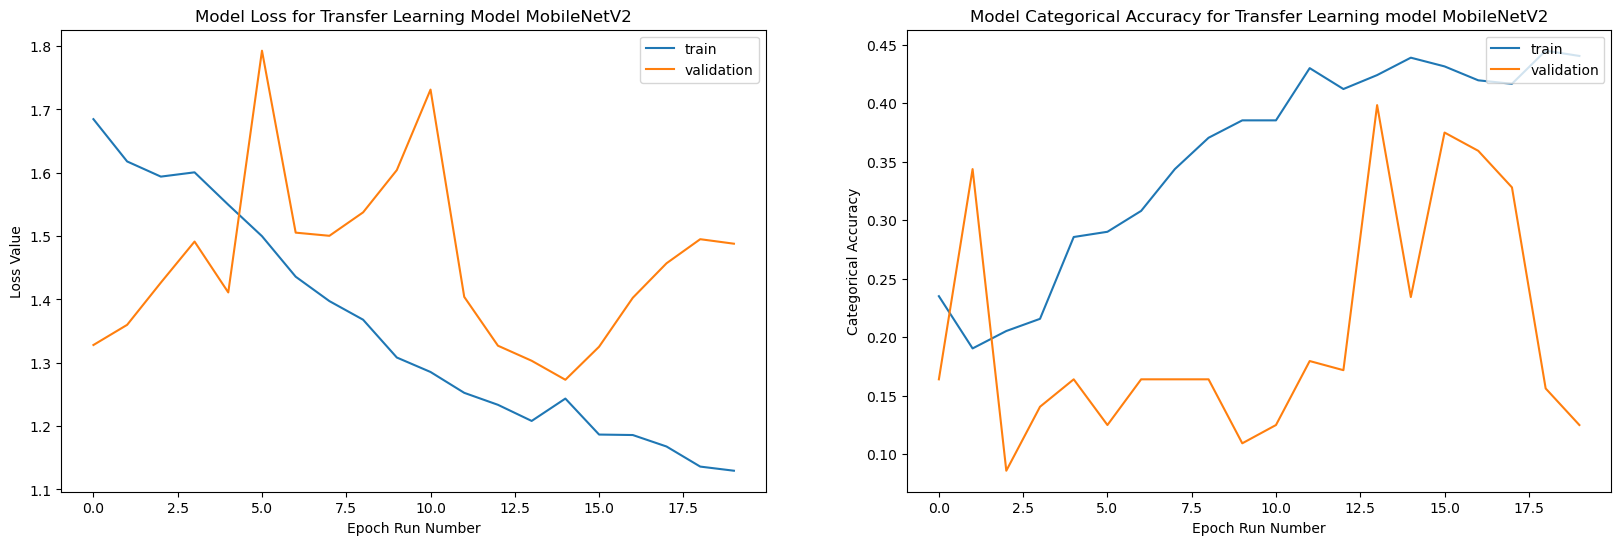

In [102]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history8.history['loss'])
ax_1 = plt.plot(history8.history['val_loss'])
plt.title('Model Loss for Transfer Learning Model MobileNetV2')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history8.history['categorical_accuracy'])
ax_2 = plt.plot(history8.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Transfer Learning model MobileNetV2')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')

- From the above Transfer Learning model using MobileNetV2, we can say that train accuracy reached max of 44% during 20 epoch runs.
- Validation Accuracy seems to be fluctuating.

### Transfer Learning Using MobileNetV2 Model 9:

In [50]:
from keras.applications import mobilenet
mobile_net=mobilenet.MobileNet(weights='imagenet',include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [51]:
model9=Sequential()
model9.add(TimeDistributed(mobile_net,input_shape=input_shape))
model9.add(BatchNormalization())
model9.add(TimeDistributed(MaxPooling2D((2,2))))
model9.add(TimeDistributed(GlobalAveragePooling2D()))

model9.add(GRU(128))

model9.add(Dense(128, activation='relu'))

model9.add(Dense(5,activation='softmax'))

In [52]:
optimiser = optimizers.Adam(lr=0.01)
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 15, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_5 (Batc  (None, 15, 2, 2, 1024)   4096      
 hNormalization)                                                 
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 128)              

In [53]:
model_name = 'model_init_exp9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [54]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [55]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [56]:
history9=model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5521 - categorical_accuracy: 0.3557Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp9_2023-06-2619_41_53.529921/model-00001-1.55207-0.35565-1.29829-0.16406.h5
21/21 [==============================] - 54s 2s/step - loss: 1.5521 - categorical_accuracy: 0.3557 - val_loss: 1.2983 - val_categorical_accuracy: 0.1641 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1377 - categorical_accuracy: 0.5298
Epoch 2: saving model to model_init_exp9_2023-06-2619_41_53.529921/model-00002-1.13773-0.52976-1.28195-0.18750.h5
21/21 [==============================] - 47s 2s/step - loss: 1.1377 - categorical_accuracy: 0.5298 - val_loss: 1.2819 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss

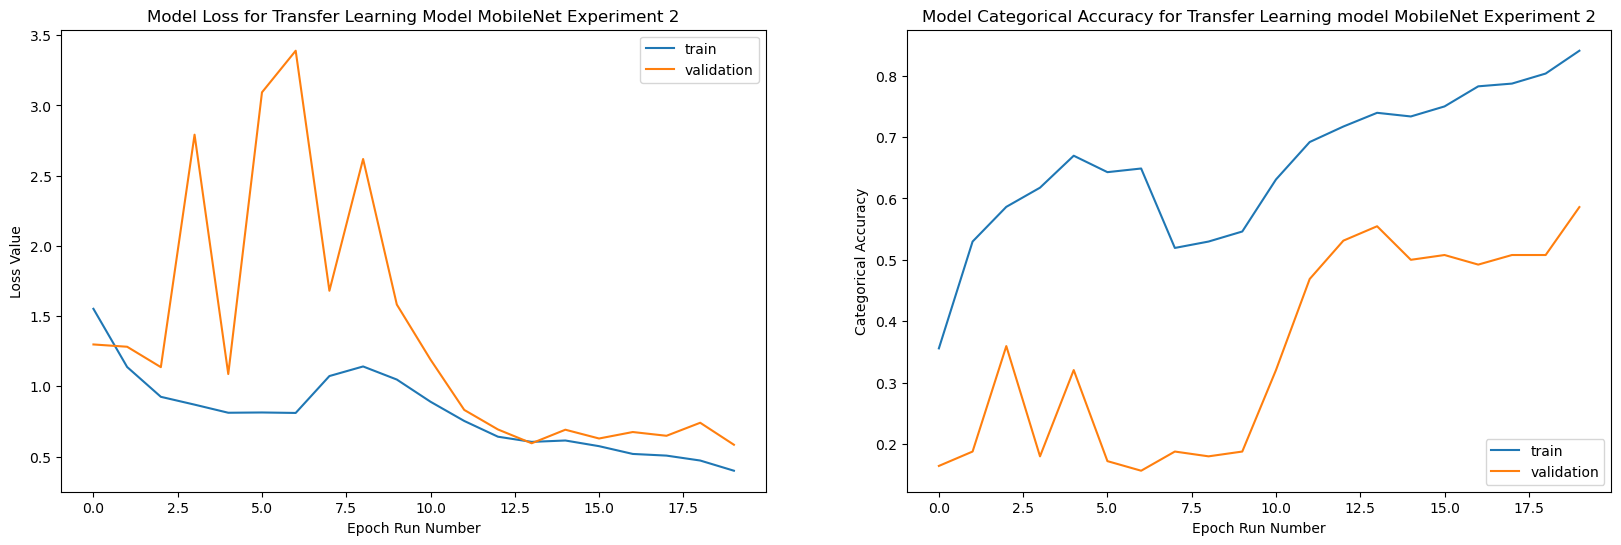

In [66]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history9.history['loss'])
ax_1 = plt.plot(history9.history['val_loss'])
plt.title('Model Loss for Transfer Learning Model MobileNet Experiment 2')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history9.history['categorical_accuracy'])
ax_2 = plt.plot(history9.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Transfer Learning model MobileNet Experiment 2')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='lower right')

### Transfer Learning Using MobileNetV2 Model 10:

In [58]:
from keras.applications import mobilenet
mobile_net=mobilenet.MobileNet(weights='imagenet',include_top=False)

In [59]:
model10=Sequential()
model10.add(TimeDistributed(mobile_net,input_shape=input_shape))
model10.add(BatchNormalization())
model10.add(TimeDistributed(MaxPooling2D((2,2))))
model10.add(TimeDistributed(GlobalAveragePooling2D()))

model10.add(GRU(128))
model10.add(Dropout(0.2))

model10.add(Dense(128, activation='relu'))
model10.add(Dropout(0.2))

model10.add(Dense(5,activation='softmax'))

In [60]:
optimiser = optimizers.Adam(lr=0.01)
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 batch_normalization_6 (Batc  (None, 15, 2, 2, 1024)   4096      
 hNormalization)                                                 
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 128)              

In [61]:
model_name = 'model_init_exp10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [62]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [63]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [64]:
history10=model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5555 - categorical_accuracy: 0.3527Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp10_2023-06-2619_41_53.529921/model-00001-1.55547-0.35268-1.35799-0.17969.h5
21/21 [==============================] - 53s 2s/step - loss: 1.5555 - categorical_accuracy: 0.3527 - val_loss: 1.3580 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.2162 - categorical_accuracy: 0.4881
Epoch 2: saving model to model_init_exp10_2023-06-2619_41_53.529921/model-00002-1.21624-0.48810-2.18364-0.17188.h5
21/21 [==============================] - 48s 2s/step - loss: 1.2162 - categorical_accuracy: 0.4881 - val_loss: 2.1836 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - lo

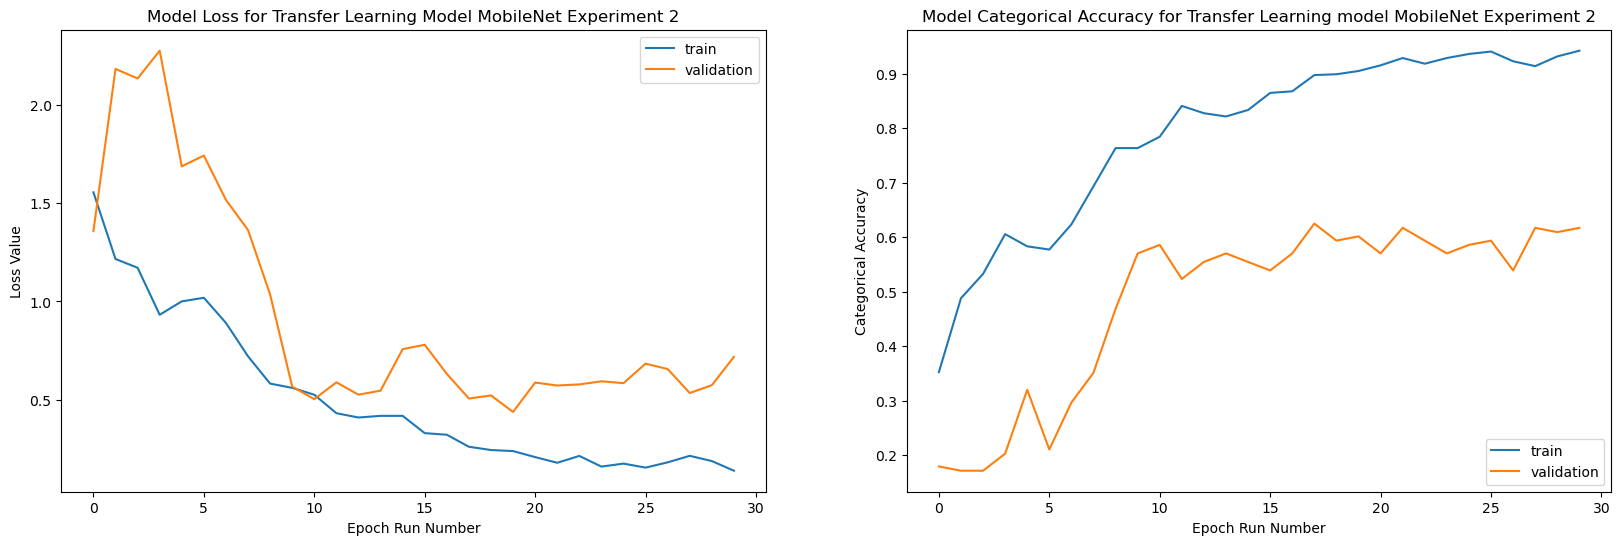

In [65]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history10.history['loss'])
ax_1 = plt.plot(history10.history['val_loss'])
plt.title('Model Loss for Transfer Learning Model MobileNet Experiment 2')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history10.history['categorical_accuracy'])
ax_2 = plt.plot(history10.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Transfer Learning model MobileNet Experiment 2')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='lower right')

### Transfer Learning using MobileNet + GRU Model 11:

In [13]:
from keras.applications import mobilenet
mobile_net=mobilenet.MobileNet(weights='imagenet',include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [14]:
model11=Sequential()
model11.add(TimeDistributed(mobile_net,input_shape=input_shape))
model11.add(BatchNormalization())
model11.add(TimeDistributed(MaxPooling2D((2,2))))
model11.add(TimeDistributed(GlobalAveragePooling2D()))

model11.add(GRU(128))
model11.add(Dropout(0.5))

model11.add(Dense(128, activation='relu'))
model11.add(Dropout(0.5))

model11.add(Dense(5,activation='softmax'))

In [15]:
optimiser = optimizers.Adam(lr=0.01)
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 2, 2, 1024)   3228864   
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 15, 2, 2, 1024)   4096      
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [16]:
model_name = 'model_init_exp11' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

In [17]:
batch_size=32
train_generator = generator(train_path, train_doc, batch_size=batch_size)
val_generator = generator(val_path, val_doc, batch_size=batch_size)

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history11=model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/motion-gesture/Project_data/train/ ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.9451 - categorical_accuracy: 0.2440Source path =  /kaggle/input/motion-gesture/Project_data/val/ ; batch size = 32

Epoch 1: saving model to model_init_exp11_2023-06-2709_22_40.663291/model-00001-1.94511-0.24405-1.33516-0.35938.h5
21/21 [==============================] - 77s 3s/step - loss: 1.9451 - categorical_accuracy: 0.2440 - val_loss: 1.3352 - val_categorical_accuracy: 0.3594 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6117 - categorical_accuracy: 0.2827
Epoch 2: saving model to model_init_exp11_2023-06-2709_22_40.663291/model-00002-1.61171-0.28274-1.14823-0.31250.h5
21/21 [==============================] - 52s 3s/step - loss: 1.6117 - categorical_accuracy: 0.2827 - val_loss: 1.1482 - val_categorical_accuracy: 0.3125 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - lo

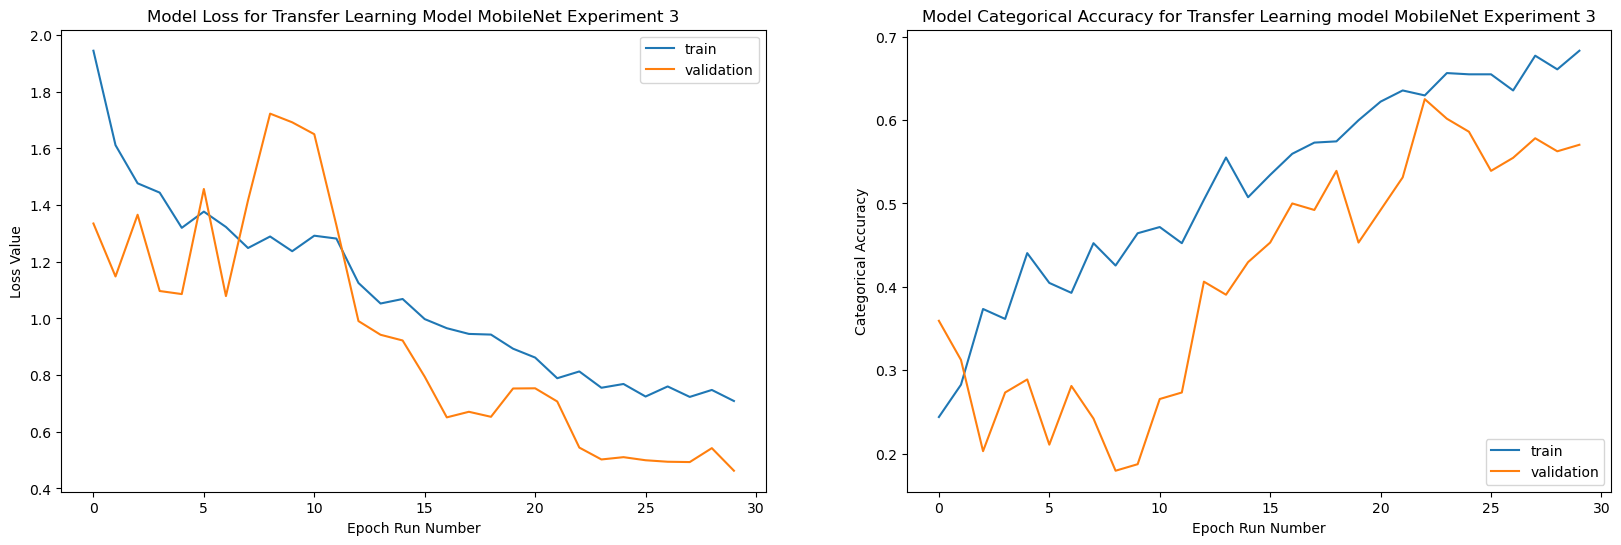

In [20]:
plt.figure(figsize=(20,6))
ax_1 = plt.subplot(121)
ax_1 = plt.plot(history11.history['loss'])
ax_1 = plt.plot(history11.history['val_loss'])
plt.title('Model Loss for Transfer Learning Model MobileNet Experiment 3')
plt.ylabel('Loss Value')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='upper right')
ax_2 = plt.subplot(122)
ax_2 = plt.plot(history11.history['categorical_accuracy'])
ax_2 = plt.plot(history11.history['val_categorical_accuracy'])
plt.title('Model Categorical Accuracy for Transfer Learning model MobileNet Experiment 3')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch Run Number')
plt.legend(['train', 'validation'], loc='lower right')

### **Conclusions**

Conv3D models have been experimented by modifying following parameters:
- without dropout
- with dropout
- with Flatten Layer
- with GlobalAveragePooling Layer

All of the above models show no satisfactory performance, which is evident by their Lower Training and Validation Accuracies.

GRU Model of 64 units have been experimented as following:
- without Dropouts
- with Dropout value 0.2

GRU with 64 units and without dropouts overfitted the data.
GRU with 64 units showed promising results with dropout layer attached. The training and Validation accuracies are satisfactory.

ConvLSTM2D model showing no satisfactory performance, which is evident from its lower Training and Validation Accuracies.

Transfer Learning Model been experimented with GRU in following manner:
- MobileNetV2 + GRU
- MobileNet + GRU without dropout
- MobileNet + GRU with dropout value 0.2
- MobileNet + GRU with dropout value 0.5

Transfer Learning Model using MobileNetV2 + GRU, showed no satisfactory performance.

**1)** Transfer Learning Model using MobileNet version 1 + GRU showed great training accuracy up to 84%, but validation accuracy is coming around 45%, suggesting overfitting.\
**2)** Thus we added drop out value of 0.2 to the above Transfer learning model and still overfitting persists. (i.e., Training accuracy is coming around 93% and Validation accuracy around 60%).\
**3)** We increased the dropout value to 0.5. Even though the overfitting problem is resolved, there is reduction in training and validation accuracies (68% and 58% respectively).

From all above experiments, We came to conclusion that GRU with 64 units and dropouts attached, is the best model for Motion Gesture Recognition. Since the performance metrics (i.e., Training and Validation Accuracy) are better and the number of parameters are low in number which is desirable.
